**Make a binary classification dataset with Scikit-Learn's make_moons() function.
For consistency, the dataset should have 1000 samples and a random_state=42.
Turn the data into PyTorch tensors. Split the data into training and test sets using train_test_split with 80% training and 20% testing.**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.cuda as cuda

In [2]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples = 1000, random_state = 42)
from sklearn.model_selection import train_test_split

In [3]:
device = 'cuda' if cuda.is_available() else 'cpu'

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train = torch.from_numpy(X_train).type(torch.float32).to(device)
X_test = torch.from_numpy(X_test).type(torch.float32).to(device)
y_train = torch.from_numpy(y_train).type(torch.float32).to(device)
y_test = torch.from_numpy(y_test).type(torch.float32).to(device)

**Build a model by subclassing nn.Module that incorporates non-linear activation functions and is capable of fitting the data you created in 1.
Feel free to use any combination of PyTorch layers (linear and non-linear) you want.**

In [5]:
class BinaryClassifier(nn.Module):
    def __init__(self, input_features, output_features, hidden_units = 8):
        super().__init__()
        self.layers = nn.Sequential(nn.Linear(in_features = input_features, out_features = hidden_units),
                                    nn.ReLU(),
                                    nn.Dropout(0.1),
                                    nn.Linear(in_features = hidden_units, out_features = hidden_units),
                                    nn.ReLU(),
                                    #nn.Dropout(0.5),
                                    nn.Linear(in_features = hidden_units, out_features = 32),
                                    nn.ReLU(),
                                    #nn.Dropout(0.1),
                                    nn.Linear(in_features = 32, out_features = output_features))
    def forward(self, x):
        return self.layers(x)

In [6]:
bclassifier = BinaryClassifier(input_features = 2, output_features = 1, hidden_units = 64).to(device)

In [7]:
bclassifier

BinaryClassifier(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=32, bias=True)
    (6): ReLU()
    (7): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [8]:
bclassifier.state_dict()

OrderedDict([('layers.0.weight',
              tensor([[-0.0341,  0.6413],
                      [ 0.4602,  0.3103],
                      [ 0.0357,  0.5656],
                      [-0.1298, -0.0944],
                      [-0.3379, -0.0369],
                      [ 0.2209, -0.6179],
                      [-0.3513, -0.3258],
                      [-0.5374,  0.6220],
                      [-0.6904, -0.0025],
                      [-0.3635,  0.0269],
                      [-0.1868,  0.6587],
                      [ 0.5504,  0.6868],
                      [-0.5583, -0.6783],
                      [-0.2933, -0.1656],
                      [-0.1144, -0.5027],
                      [ 0.1923,  0.3275],
                      [ 0.4766, -0.4794],
                      [-0.4361,  0.0587],
                      [ 0.3388,  0.6744],
                      [-0.0917, -0.5982],
                      [ 0.5956,  0.1813],
                      [-0.1254,  0.1186],
                      [-0.4833, -0.3538],
 

**Setup a binary classification compatible loss function and optimizer to use when training the model.**

In [9]:
bloss_fn = nn.BCEWithLogitsLoss()
bopt_fn = torch.optim.Adam(params = bclassifier.parameters(), lr = 0.001)

**Create a training and testing loop to fit the model you created in 2 to the data you created in 1.
To measure model accuray, you can create your own accuracy function or use the accuracy function in TorchMetrics.
Train the model for long enough for it to reach over 96% accuracy.
The training loop should output progress every 10 epochs of the model's training and test set loss and accuracy.**

In [10]:
import torchmetrics
acc = torchmetrics.Accuracy(task = 'binary', num_classes = 2).to(device)
prec = torchmetrics.Precision(task = 'binary', num_classes = 2).to(device)
rec = torchmetrics.Recall(task = 'binary', num_classes = 2).to(device)

In [11]:
epochs = 100
torch.manual_seed(42)
for i in range(epochs):
    #Train mode
    bclassifier.train()
    #Forward pass
    #Train Logits
    train_logits = bclassifier(X_train).squeeze()
    #Train Labels
    train_pred_labels = torch.round(torch.sigmoid(train_logits))
    #Train Loss
    train_loss = bloss_fn(train_logits, y_train)
    #Train Acc
    train_acc = acc(y_train.type(torch.long), train_pred_labels)
    #Resetting optimizer 
    bopt_fn.zero_grad()
    #Backpropagation
    train_loss.backward()
    #Stepping the optimizer
    bopt_fn.step()
    #Evaluation mode
    bclassifier.eval()
    #Inference mode
    with torch.inference_mode():
        #Forward pass
        #Test Logits
        test_logits = bclassifier(X_test).squeeze()
        #Test labels
        test_pred_labels = torch.round(torch.sigmoid(test_logits))
        #Test Loss
        test_loss = bloss_fn(test_logits, y_test)
        #Test Accuracy
        test_acc = acc(y_test.type(torch.long), test_pred_labels)
    if ((i + 1)% 10 == 0):
        print(f'Epoch: {i + 1} | Train Loss: {train_loss} | Train Accuracy: {train_acc} % | Test Loss: {test_loss} | Test Accuracy: {test_acc} %')

Epoch: 10 | Train Loss: 0.6559141278266907 | Train Accuracy: 0.8450000286102295 % | Test Loss: 0.6519527435302734 | Test Accuracy: 0.8500000238418579 %
Epoch: 20 | Train Loss: 0.5940691232681274 | Train Accuracy: 0.8324999809265137 % | Test Loss: 0.5911771059036255 | Test Accuracy: 0.8399999737739563 %
Epoch: 30 | Train Loss: 0.5015884637832642 | Train Accuracy: 0.8324999809265137 % | Test Loss: 0.49954500794410706 | Test Accuracy: 0.8450000286102295 %
Epoch: 40 | Train Loss: 0.3863535225391388 | Train Accuracy: 0.8500000238418579 % | Test Loss: 0.39193063974380493 | Test Accuracy: 0.8500000238418579 %
Epoch: 50 | Train Loss: 0.2934815585613251 | Train Accuracy: 0.8662499785423279 % | Test Loss: 0.29539400339126587 | Test Accuracy: 0.8799999952316284 %
Epoch: 60 | Train Loss: 0.2285880446434021 | Train Accuracy: 0.8999999761581421 % | Test Loss: 0.22413542866706848 | Test Accuracy: 0.9049999713897705 %
Epoch: 70 | Train Loss: 0.17970186471939087 | Train Accuracy: 0.9287499785423279 % |

**Make predictions with your trained model and plot them using the plot_decision_boundary() function created in this notebook.**

In [12]:
bclassifier.eval()
with torch.inference_mode():
    y_logits = bclassifier(X_test)
    y_pred_labels = torch.round(torch.sigmoid(bclassifier(X_test).squeeze()))

In [13]:
y_pred_labels

tensor([1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
        1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0.,
        0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
        1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0.,
        0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0.,
        1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
        0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1.,
        1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0.,
        0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0.,
        1., 1.], device='cuda:0')

In [14]:
y_pred_labels == y_test

tensor([ True,  True,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False,  True,  True,  True,  True,  True,
         True,  True, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, 

**Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch**

In [15]:
def tanh(X: torch.Tensor) -> torch.Tensor:
    return (torch.exp(X) - torch.exp(-X)) / (torch.exp(X) + torch.exp(-X))

In [16]:
tanh(y_logits)

tensor([[ 0.9996],
        [-0.9993],
        [ 0.9998],
        [-0.9996],
        [ 0.9992],
        [ 0.9973],
        [-0.8788],
        [ 0.2377],
        [ 0.9998],
        [-0.9989],
        [-0.9998],
        [ 0.9996],
        [-0.3167],
        [ 0.9999],
        [-0.9999],
        [ 0.8575],
        [ 0.9977],
        [-0.9999],
        [ 0.9996],
        [-0.9999],
        [-0.9992],
        [-0.9968],
        [ 0.9997],
        [-0.9999],
        [-0.9656],
        [-0.5213],
        [-0.9999],
        [-0.9992],
        [-0.9999],
        [ 0.9999],
        [ 0.9804],
        [-0.9798],
        [-0.9997],
        [ 0.9998],
        [-0.9998],
        [ 0.9992],
        [ 0.9996],
        [ 0.9999],
        [ 0.9999],
        [ 0.9999],
        [ 0.9997],
        [ 0.9997],
        [ 0.9969],
        [-0.9998],
        [-0.9997],
        [ 0.9989],
        [-0.9997],
        [-0.9992],
        [ 0.9992],
        [ 0.9988],
        [-0.9996],
        [-0.9997],
        [-0.

**Create a multi-class dataset using the spirals data creation function from CS231n (see below for the code).
Construct a model capable of fitting the data (you may need a combination of linear and non-linear layers).
Build a loss function and optimizer capable of handling multi-class data (optional extension: use the Adam optimizer instead of SGD, you may have to experiment with different values of the learning rate to get it working).
Make a training and testing loop for the multi-class data and train a model on it to reach over 95% testing accuracy (you can use any accuracy measuring function here that you like).
Plot the decision boundaries on the spirals dataset from your model predictions, the plot_decision_boundary() function should work for this dataset too.**

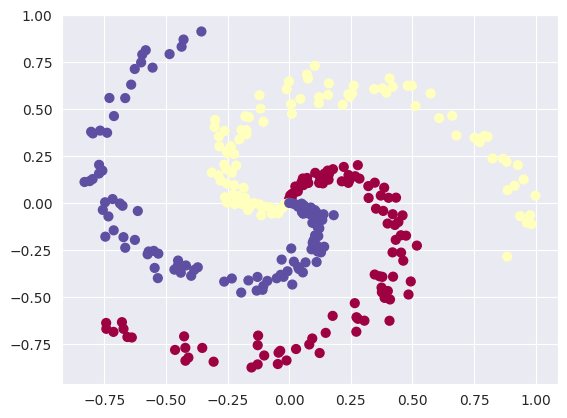

In [17]:
# Code for creating a spiral dataset from CS231n
import numpy as np
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [18]:
X.shape

(300, 2)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train = torch.from_numpy(X_train).type(torch.float32).to(device)
X_test = torch.from_numpy(X_test).type(torch.float32).to(device)
y_train = torch.from_numpy(y_train).type(torch.float32).to(device)
y_test = torch.from_numpy(y_test).type(torch.float32).to(device)

In [20]:
class MultiClassClassifier(nn.Module):
    def __init__(self, input_features, output_features, hidden_units = 8):
        super().__init__()
        self.fc_layers = nn.Sequential(nn.Linear(in_features = input_features, out_features = 128),
                                       nn.ReLU(),
                                       nn.Dropout(0.5),
                                       nn.Linear(in_features = 128, out_features = 64),
                                       nn.ReLU(),
                                       nn.Dropout(0.5),
                                       nn.Linear(in_features = 64, out_features = 64),
                                       nn.ReLU(),
                                       nn.Linear(in_features = 64, out_features = output_features))
                                       
    def forward(self, x):
        return self.fc_layers(x)

In [21]:
mclassifier = MultiClassClassifier(input_features = 2, output_features = 3).to(device)

In [22]:
mclassloss_fn = nn.CrossEntropyLoss()
mclassopt_fn = torch.optim.Adam(params = mclassifier.parameters(), lr = 0.0025)

In [23]:
#Perf metrics
mclass_acc = torchmetrics.Accuracy(task = 'multiclass', num_classes = 3).to(device)
mclass_prec = torchmetrics.Precision(task = 'multiclass', num_classes = 3).to(device)
mclass_rec = torchmetrics.Recall(task = 'multiclass', num_classes = 3).to(device)

In [24]:
#Train and test loops
epochs = 100
for i in range(epochs):
    #Train mode
    mclassifier.train()
    #Forward Pass
    train_logits = mclassifier(X_train).squeeze()
    train_pred_labels = torch.softmax(train_logits, dim = 1).argmax(dim = 1)
    #Loss
    train_loss = mclassloss_fn(train_logits, y_train.type(torch.long))
    #Accuracy
    train_acc = mclass_acc(y_train, train_pred_labels)
    #Reset optimizer
    mclassopt_fn.zero_grad()
    #Backpropagation
    train_loss.backward()
    #Stepping the optimizer
    mclassopt_fn.step()
    #Eval mode
    mclassifier.eval()
    #Inference mode
    with torch.inference_mode():
        #Forward Pass
        test_logits = mclassifier(X_test).squeeze()
        test_pred_labels = torch.softmax(test_logits, dim = 1).argmax(dim = 1)
        #Loss
        test_loss = mclassloss_fn(test_logits, y_test.type(torch.long))
        #Accuracy
        test_acc = mclass_acc(y_test.type(torch.long), test_pred_labels)
    print(f'Epoch {i +1} | Train Loss: {train_loss} | Train Accuracy: {train_acc} % | Test Loss: {test_loss} | Test Accuracy: {test_acc} % ')

Epoch 1 | Train Loss: 1.101372480392456 | Train Accuracy: 0.32499998807907104 % | Test Loss: 1.0927001237869263 | Test Accuracy: 0.4333333373069763 % 
Epoch 2 | Train Loss: 1.0955851078033447 | Train Accuracy: 0.375 % | Test Loss: 1.0831907987594604 | Test Accuracy: 0.44999998807907104 % 
Epoch 3 | Train Loss: 1.0878599882125854 | Train Accuracy: 0.4166666567325592 % | Test Loss: 1.0744426250457764 | Test Accuracy: 0.5666666626930237 % 
Epoch 4 | Train Loss: 1.0679728984832764 | Train Accuracy: 0.46666666865348816 % | Test Loss: 1.0652157068252563 | Test Accuracy: 0.6000000238418579 % 
Epoch 5 | Train Loss: 1.0664631128311157 | Train Accuracy: 0.4958333373069763 % | Test Loss: 1.0539097785949707 | Test Accuracy: 0.5333333611488342 % 
Epoch 6 | Train Loss: 1.0537196397781372 | Train Accuracy: 0.4833333194255829 % | Test Loss: 1.0406862497329712 | Test Accuracy: 0.46666666865348816 % 
Epoch 7 | Train Loss: 1.0492044687271118 | Train Accuracy: 0.5166666507720947 % | Test Loss: 1.026481389

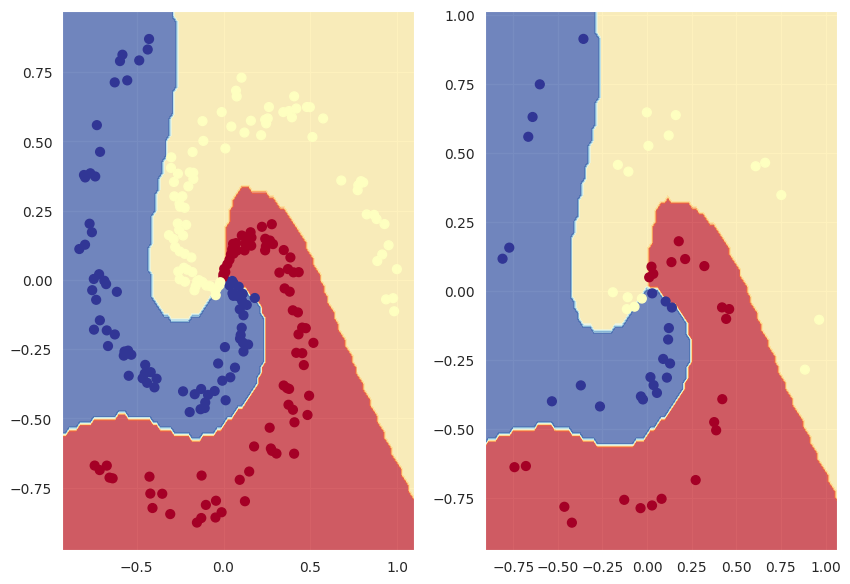

In [25]:
#Plotting the decision boundaries for the multiclass classification model
from helper_functions import plot_decision_boundary
plt.figure(figsize = (10, 7))
plt.subplot(1, 2, 1)
plot_decision_boundary(mclassifier, X_train, y_train)
plt.subplot(1, 2, 2)
plot_decision_boundary(mclassifier, X_test, y_test)

In [31]:
mclassifier.eval()
with torch.inference_mode():
    y_pred_labels = torch.softmax(mclassifier(X_test.cpu()).squeeze(), dim = 1).argmax(dim = 1)

In [32]:
y_pred_labels

tensor([2, 2, 1, 0, 2, 2, 1, 1, 0, 1, 2, 0, 2, 0, 1, 2, 2, 2, 1, 1, 0, 1, 2, 2,
        2, 0, 2, 2, 1, 2, 0, 1, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2,
        1, 2, 1, 1, 2, 0, 2, 2, 0, 0, 1, 0])

In [33]:
y_test

tensor([2., 2., 1., 0., 2., 2., 1., 1., 0., 1., 2., 0., 2., 0., 1., 2., 2., 2.,
        1., 1., 0., 1., 2., 2., 1., 0., 2., 2., 1., 2., 0., 1., 0., 0., 2., 1.,
        0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 2., 2., 1., 2., 1., 1., 2., 0.,
        2., 2., 0., 0., 1., 0.], device='cuda:0')

In [35]:
y_pred_labels == y_test.cpu()

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True])